# Challenge#3: How can we turn this Random Forest into a garden (aka how to enhance it)? 

## Load libraries

In [1]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from dslectures.core import rmse, make_polynomial_data, PolynomialRegressor, get_dataset
from dslectures.structured import proc_df

np.warnings.filterwarnings('ignore')

## Helper functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

def plot_fitting_graph(x, metric_train, metric_valid, metric_name='metric', xlabel='x', yscale='linear'):
    plt.plot(x, metric_train, label='train')
    plt.plot(x, metric_valid, label='valid')
    plt.yscale(yscale)
    plt.title('Fitting graph')
    plt.ylabel(metric_name)
    plt.xlabel(xlabel)
    plt.legend(loc='best')
    plt.grid(True)

## Download and read the processed California's hosuing dataset

In [4]:
get_dataset('housing_processed.csv')

Dataset already exists at '../data/housing_processed.csv' and is not downloaded again.


In [5]:
DATA = Path('../data/')
housing_data = pd.read_csv(DATA/'housing_processed.csv')
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,city,postal_code,rooms_per_household,bedrooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_<1H OCEAN,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,69,94705,6.984127,1.023810,0.146591,2.555556,0,0,1,0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,620,94611,6.238137,0.971880,0.155797,2.109842,0,0,1,0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,620,94618,8.288136,1.073446,0.129516,2.802260,0,0,1,0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,620,94618,5.817352,1.073059,0.184458,2.547945,0,0,1,0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,620,94618,6.281853,1.081081,0.172096,2.181467,0,0,1,0,0


In [6]:
X = housing_data.drop('median_house_value', axis=1).values
y = housing_data['median_house_value'].values

## Fitting and evalutating a Random Forest Regressor

In [7]:
rf = RandomForestRegressor(n_jobs=-1)
results = cross_validate(rf, X, y,
                         cv=5,
                         return_train_score=True,
                         scoring='neg_root_mean_squared_error')
print('Train score: %.1f' % -np.mean(results['train_score']))
print('Validation score: %.1f' % -np.mean(results['test_score']))

Train score: 15739.3
Validation score: 60688.0


In [8]:
rmse_train = []
rmse_valid = []

for i in tqdm(np.linspace(5, X.shape[0], 10, dtype=int)):
    rf = RandomForestRegressor(n_jobs=-1)
    results = cross_validate(rf, X[:i, :], y[:i],
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|███████████████████████████████████████████| 10/10 [02:26<00:00, 14.65s/it]


Now we tune one parameter after another and always choose the best one of the round based on the fitting curve.

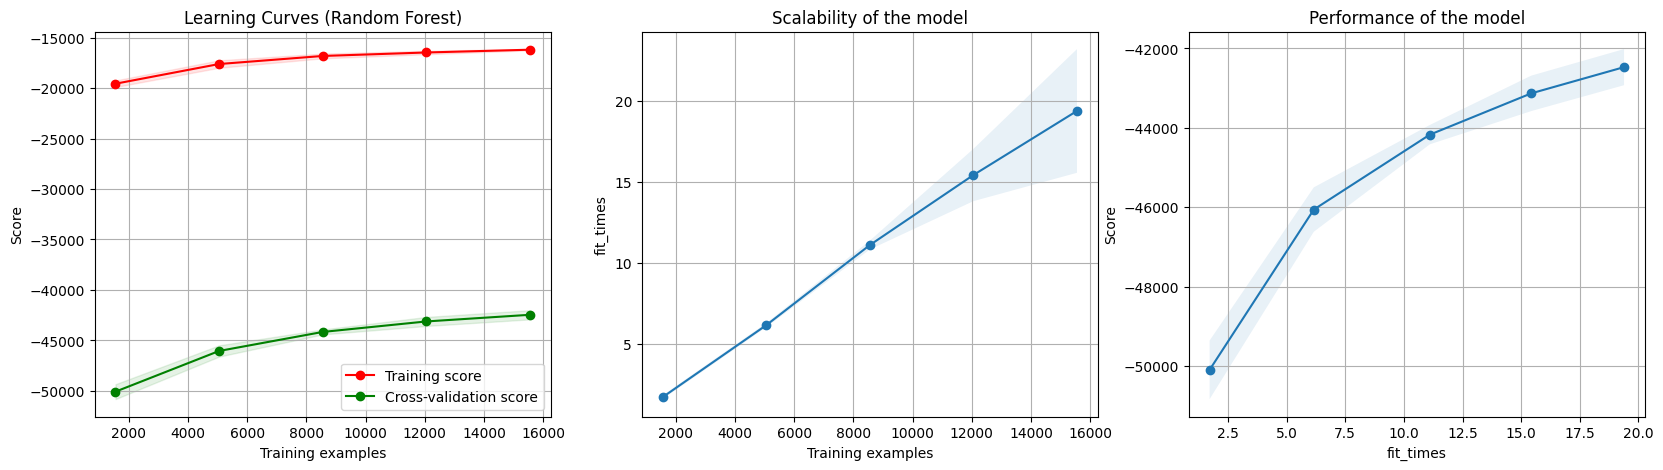

In [9]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = r"Learning Curves (Random Forest)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = RandomForestRegressor(n_jobs=-1)
plot_learning_curve(
    estimator, title, X, y, cv=cv, n_jobs=4, scoring='neg_root_mean_squared_error'
)

plt.show()

## Hyperparameters Tuning 

### n_estimators

In [10]:
rmse_train = []
rmse_valid = []

n_estimators = [25, 50, 100, 200]
for n in tqdm(n_estimators):
    rf = RandomForestRegressor(n_estimators=n, n_jobs=-1)
    results = cross_validate(rf, X, y,
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|█████████████████████████████████████████████| 4/4 [01:53<00:00, 28.29s/it]


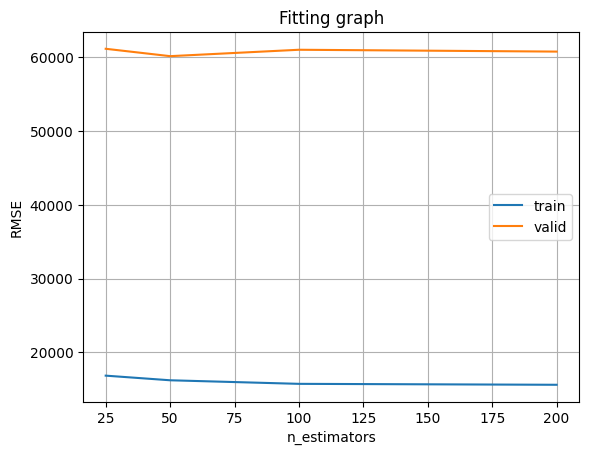

In [11]:
plot_fitting_graph(n_estimators, rmse_train, rmse_valid, metric_name='RMSE', xlabel='n_estimators')

We can zoom in a little bit further to get a better picture of how the validation error behaves:

We see that adding more estimaters further decreases the validation error. We do not overfit by adding more estimators. However, it takes longer to train and evaluate the model as we add more estimators. This is usually not a major concern when experimenting with models but it can be a major constraint when putting it in production. See [this](https://www.wired.com/2012/04/netflix-prize-costs/) example from Netflix.

We choose `n_estimators=100` for the sake of speed but we keep in mind that we could probably further improve the model by adding more estimators. We continue tuning the other parameters:

### tree_depth

In [12]:
rmse_train = []
rmse_valid = []

max_depths = [1, 2, 4, 8, 16, 32, 64]
for d in tqdm(max_depths):
    rf = RandomForestRegressor(n_estimators=100, max_depth=d, n_jobs=-1)
    results = cross_validate(rf, X, y,
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|█████████████████████████████████████████████| 7/7 [01:51<00:00, 15.88s/it]


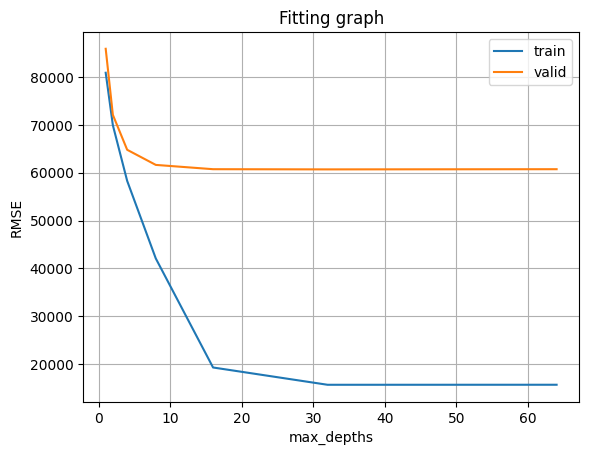

In [13]:
plot_fitting_graph(max_depths, rmse_train, rmse_valid, metric_name='RMSE', xlabel='max_depths')

In [14]:
max_depths[np.argmin(rmse_valid)]

32

### min_samples_leaf

In [15]:
rmse_train = []
rmse_valid = []

min_samples_leaf = [1, 3, 5, 10, 25]
for s in tqdm(min_samples_leaf):
    rf = RandomForestRegressor(n_estimators=100, max_depth=16, min_samples_leaf=s, n_jobs=-1)
    results = cross_validate(rf, X, y,
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|█████████████████████████████████████████████| 5/5 [01:45<00:00, 21.03s/it]


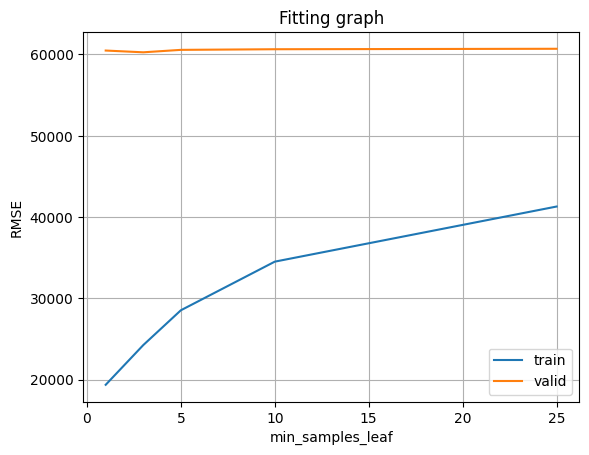

In [16]:
plot_fitting_graph(min_samples_leaf, rmse_train, rmse_valid, metric_name='RMSE', xlabel='min_samples_leaf')

In [17]:
min_samples_leaf[np.argmin(rmse_valid)]

3

### max_features

In [18]:
rmse_train = []
rmse_valid = []

max_features = [.1, .25, .5, .75, 1.]
for mf in tqdm(max_features):
    rf = RandomForestRegressor(n_estimators=100, max_depth=32, min_samples_leaf=5, max_features=mf, n_jobs=-1)
    results = cross_validate(rf, X, y,
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|█████████████████████████████████████████████| 5/5 [01:04<00:00, 12.95s/it]


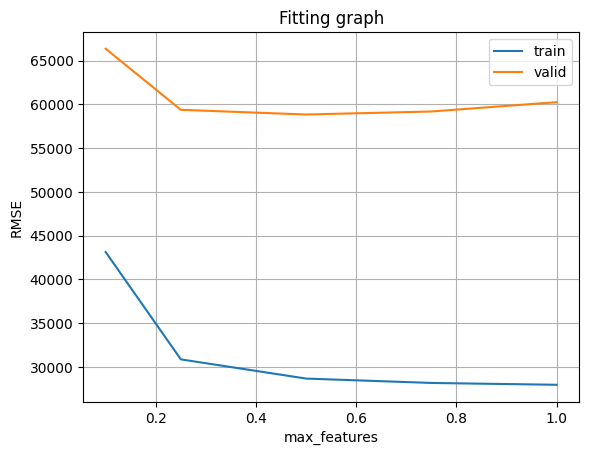

In [19]:
plot_fitting_graph(max_features, rmse_train, rmse_valid, metric_name='RMSE', xlabel='max_features')

In [20]:
max_features[np.argmin(rmse_valid)]

0.5

## Did we resovle the high variance by tuning the hyperparameters? 

In [21]:
rf = RandomForestRegressor(n_estimators=100, max_depth=32, min_samples_leaf=5, max_features=0.5, n_jobs=-1)
results = cross_validate(rf, X, y,
                         cv=5,
                         return_train_score=True,
                         scoring='neg_root_mean_squared_error')

In [22]:
print('Train score: %.1f' % -np.mean(results['train_score']))
print('Validation score: %.1f' % -np.mean(results['test_score']))

Train score: 28671.4
Validation score: 58868.8


We see that we improved the RMSE on the validation set by more than $2000 which corresponds to 3-4% improvement!

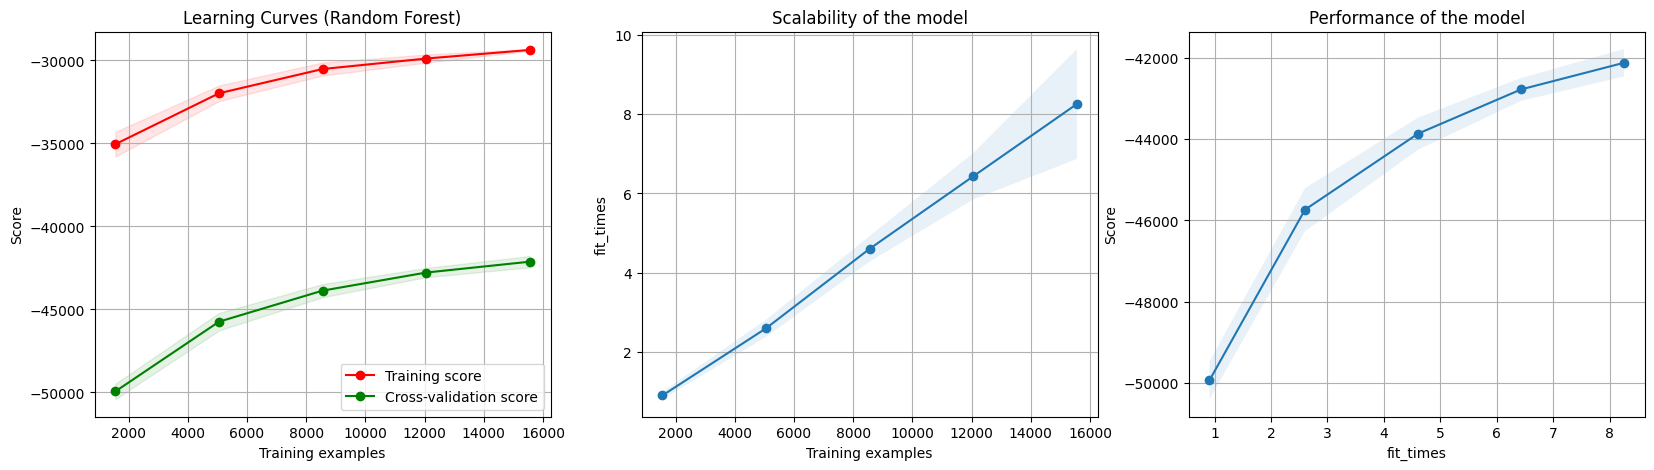

In [23]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = r"Learning Curves (Random Forest)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = RandomForestRegressor(n_estimators=100, max_depth=32, min_samples_leaf=5, max_features=0.5, n_jobs=-1)
plot_learning_curve(
    estimator, title, X, y, cv=cv, n_jobs=4, scoring='neg_root_mean_squared_error'
)

plt.show()